In [1]:
import numpy as np
import tensorflow as tf
import srez_model as sm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
X = tf.placeholder(tf.float32, [100, 28, 28, 1], "input")
tmp = tf.placeholder(tf.float32, [100, 28, 28, 1], "intermeadia")
Y_ = tf.placeholder(tf.float32, [100, 10], "true_labels")

In [3]:
tmp = X
model_cnn_re = sm.Model('cnn-reuse', tmp)

In [4]:
model_cnn_re = model_cnn_re.add_conv2d(4, mapsize = 5, stddev_factor = 2.0)
model_cnn_re = model_cnn_re.add_relu()
model_cnn_re.get_output()

Instructions for updating:
Colocations handled automatically by placer.


<tf.Tensor 'cnn-reuse_L003/Relu:0' shape=(100, 28, 28, 4) dtype=float32>

In [6]:
model_cnn_re = model_cnn_re.add_conv2d(1, mapsize = 1) # a bottleneck-ish layer
runtime = 3
for i in range(runtime):
    tmp = model_cnn_re.get_output()

In [10]:
model_af = sm.Model('pats_after_cnn_reuse', tmp)

In [11]:
model_af = model_af.add_batch_norm()
model_af = model_af.add_conv2d(5, mapsize = 7, stride = 2, stddev_factor = 2.0)
model_af = model_af.add_relu()
model_af = model_af.add_conv2d(5, mapsize = 4, stride = 2, stddev_factor = 2.0)
model_af = model_af.add_relu()
model_af = model_af.add_conv2d(1, mapsize = 1)
model_af = model_af.add_relu()
model_af = model_af.add_flatten()
model_af = model_af.add_dense(10, stddev_factor = 2.0)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [12]:
model_af.get_output()

<tf.Tensor 'pats_after_cnn_reuse_L010/add:0' shape=(100, 10) dtype=float32>

In [13]:
Ylogits = model_af.get_output()
Y = tf.nn.softmax(Ylogits)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=Ylogits, labels=Y_)
cross_entropy = tf.reduce_mean(cross_entropy)*100

correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(Y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [14]:
tf.global_variables()

[<tf.Variable 'cnn-reuse_L002/weight:0' shape=(5, 5, 1, 4) dtype=float32_ref>,
 <tf.Variable 'cnn-reuse_L002/bias:0' shape=(4,) dtype=float32_ref>,
 <tf.Variable 'cnn-reuse_L004/weight:0' shape=(1, 1, 4, 1) dtype=float32_ref>,
 <tf.Variable 'cnn-reuse_L004/bias:0' shape=(1,) dtype=float32_ref>,
 <tf.Variable 'cnn-reuse_L005/weight:0' shape=(1, 1, 1, 1) dtype=float32_ref>,
 <tf.Variable 'cnn-reuse_L005/bias:0' shape=(1,) dtype=float32_ref>,
 <tf.Variable 'pats_after_cnn_reuse_L002/BatchNorm/beta:0' shape=(1,) dtype=float32_ref>,
 <tf.Variable 'pats_after_cnn_reuse_L002/BatchNorm/moving_mean:0' shape=(1,) dtype=float32_ref>,
 <tf.Variable 'pats_after_cnn_reuse_L002/BatchNorm/moving_variance:0' shape=(1,) dtype=float32_ref>,
 <tf.Variable 'pats_after_cnn_reuse_L003/weight:0' shape=(7, 7, 1, 5) dtype=float32_ref>,
 <tf.Variable 'pats_after_cnn_reuse_L003/bias:0' shape=(5,) dtype=float32_ref>,
 <tf.Variable 'pats_after_cnn_reuse_L005/weight:0' shape=(4, 4, 5, 5) dtype=float32_ref>,
 <tf.Var

In [15]:
((train_data, train_labels),
 (eval_data, eval_labels)) = tf.keras.datasets.mnist.load_data()


train_data = train_data/np.float32(255)
train_labels = train_labels.astype(np.int32)  # not required

eval_data = eval_data/np.float32(255)
eval_labels = eval_labels.astype(np.int32)  # not required

In [16]:
def get_batch(size):
    batch_loc = np.random.randint(60000, size=size)
    train_bat_lab = np.zeros((size,10))
    train_bat_lab[np.arange(size), train_labels[batch_loc]] = 1
    train_bat_im = train_data[batch_loc]
    return np.reshape(train_bat_im,[size, 28, 28, 1]), train_bat_lab

In [17]:
import math
step = tf.placeholder(tf.int32,name= "step")
lr = 0.0001 +  tf.train.exponential_decay(0.003, step, 2000, 1/math.e)
train_step = tf.train.AdamOptimizer(lr).minimize(cross_entropy)

In [18]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [19]:
import time
def train_process(epochs, batch_size):
    start_time = time.time()
    train_log = []
    train_time = 0
    while train_time<epochs:
        batch_X, batch_Y = get_batch(batch_size)
        a = sess.run(accuracy, feed_dict = {X:batch_X, Y_:batch_Y, step: train_time})
        train_log.append(a)
        #print("epoch: "+str(train_time)+", accuracy: "+str(a))
        train_time+=1
        sess.run(train_step, feed_dict={X:batch_X, Y_:batch_Y, step: train_time})
    plt.figure(figsize = (16, 10))
    plt.plot(train_log)
    plt.title("Training Accuracy")
    plt.show()
    print("training time:"+ str(time.time() - start_time)+" seconds")
    return train_log

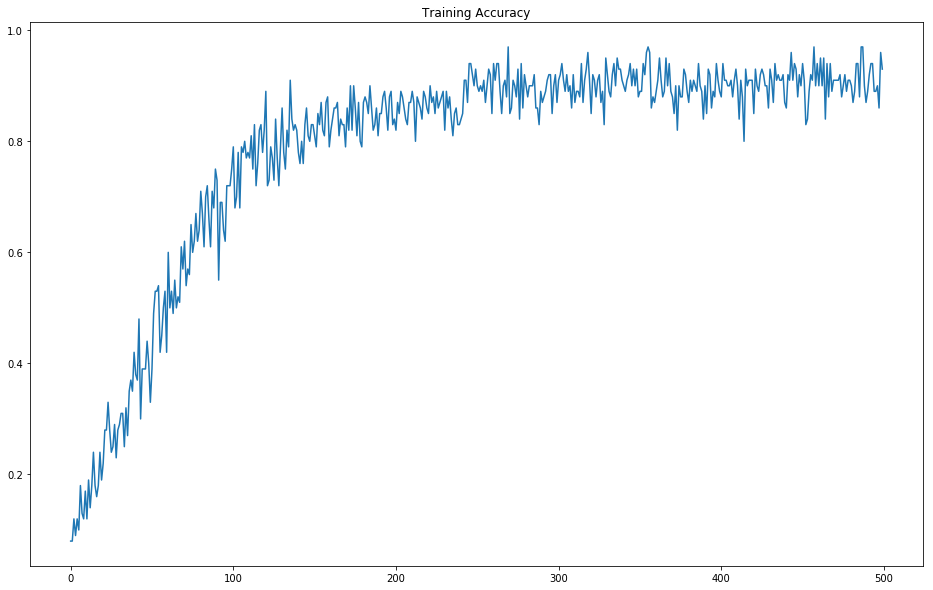

training time:32.783562898635864 seconds


In [20]:
train_log = train_process(500, 100)

In [21]:
eval_lab = np.zeros((100,10))
eval_lab[np.arange(100),eval_labels[:100]] = 1
eval_im = np.reshape(eval_data[:100][:][:][:], [100, 28, 28 ,1])
print(sess.run(accuracy, feed_dict = {X:eval_im, Y_:eval_lab}))

0.94
